In [6]:
import h5py

# Load the HDF5 file
file_path = '/global/cfs/cdirs/m3246/vmikuni/for_nishank/Aachen/train_ttbar.h5'
with h5py.File(file_path, 'r') as f:
    # Check the structure of the file
    print(list(f.keys()))  # Lists all the top-level groups in the file
    
    # Assuming there's a dataset called 'jets'
    jets_dataset = f['jet']
    print("Number of events in jets class:", jets_dataset.shape[0])  # Prints the number of events


['data', 'jet', 'pid']
Number of events in jets class: 1600000


In [3]:
import os
import numpy as np
import h5py
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
import string
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Dense, Input, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def random_string():
    # initializing size of string
    N = 7
    # using random.choices() to generate random strings
    res = ''.join(random.choices(string.ascii_uppercase + string.digits, k=N))
    return str(res)

def load_data(file, num_events, num_const):
    if file.endswith("npz"):
        dat = np.load(file)["jets"][:num_events, :num_const]
    elif file.endswith("h5"):
        dat = pd.read_hdf(file, key="discretized", stop=num_events)
        dat = dat.to_numpy(dtype=np.int64)[:, :num_const * 3]
        dat = dat.reshape(dat.shape[0], -1, 3)
    else:
        raise ValueError("Filetype not supported")
    dat = np.delete(dat, np.where(dat[:, 0, 0] == 0)[0], axis=0)
    dat[dat == -1] = 0
    return dat

def get_data(bg_file, sig_file, num_events, num_const, batch_size):
    bg = load_data(bg_file, num_events, num_const)
    sig = load_data(sig_file, num_events, num_const)

    print(f"Using bg {bg.shape} from {bg_file} and sig {sig.shape} from {sig_file}")

    dat = np.concatenate((bg, sig), 0)
    lab = np.append(np.zeros(len(bg)), np.ones(len(sig)))
    padding_mask = dat[:, :, 0] != 0

    idx = np.random.permutation(len(dat))
    dat = torch.tensor(dat[idx])
    lab = torch.tensor(lab[idx])
    padding_mask = torch.tensor(padding_mask[idx])

    train_size = int(0.9 * len(dat))
    val_size = len(dat) - train_size

    train_data = TensorDataset(dat[:train_size], padding_mask[:train_size], lab[:train_size])
    val_data = TensorDataset(dat[train_size:], padding_mask[train_size:], lab[train_size:])

    return train_data, val_data

# Parameters
main_dir_discrete = '/pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/'
sig_list = ['top/discrete/samples_samples_nsamples1000000_trunc_5000.h5']
#sig_list = ['top/raw/train_nsamples1000000_trunc_5000.h5']
bg_list = ['qcd/discrete/samples_samples_nsamples1000000_trunc_5000.h5']
#bg_list = ['qcd/raw/train_nsamples1000000_trunc_5000.h5']
num_epochs_list = [50]
dropout_list = [0.0]
num_heads_list = [4]
num_layers_list = [8]
hidden_dim_list = [256]
batch_size_list = [100]
num_events_list = [1000000]
num_const_list = [100]
lr_list = [0.001]

tag_of_train = 'top_vs_qcd_transformerdata_classifier_test_2'
log_dir = '/pscratch/sd/n/nishank/humberto/log_dir/' + tag_of_train

# Sample parameters for this run
sig = sig_list[0]
bg = bg_list[0]
num_events = num_events_list[0]
num_const = num_const_list[0]
batch_size = batch_size_list[0]

sig_path = main_dir_discrete + sig
bg_path = main_dir_discrete + bg

# Generate random suffix for this run
name_sufix = random_string()
print('Random String:', name_sufix)
print('Loading Data...')
# Load the data
train_data, val_data = get_data(bg_path, sig_path, num_events, num_const, batch_size)
print('Loaded Data.')
import numpy as np

def tensor_to_numpy(tensor_dataset):
    data_list = []
    mask_list = []
    label_list = []
    for data, mask, label in tensor_dataset:
        data_list.append(data.numpy())
        mask_list.append(mask.numpy())
        label_list.append(label.numpy())
    data_array = np.array(data_list)
    mask_array = np.array(mask_list)
    label_array = np.array(label_list)
    return data_array, mask_array, label_array

# Convert train_data and val_data to NumPy arrays
train_data_np, train_mask_np, train_labels_np = tensor_to_numpy(train_data)
val_data_np, val_mask_np, val_labels_np = tensor_to_numpy(val_data)

# Print shapes to confirm
print("Train data shape:", train_data_np.shape)
print("Train mask shape:", train_mask_np.shape)
print("Train labels shape:", train_labels_np.shape)
print("Validation data shape:", val_data_np.shape)
print("Validation mask shape:", val_mask_np.shape)
print("Validation labels shape:", val_labels_np.shape)


print('Loaded Train/Val Data')

# Define the model architecture as described
def DeepSetsAttClass(num_feat, num_heads=4, num_transformer=4, projection_dim=32):
    inputs = Input((None, num_feat))
    masked_inputs = layers.Masking(mask_value=0.0, name='Mask')(inputs)

    masked_features = TimeDistributed(Dense(projection_dim, activation=None))(masked_inputs)
    
    tdd = TimeDistributed(Dense(projection_dim, activation=None))(masked_features)
    tdd = TimeDistributed(layers.LeakyReLU(alpha=0.01))(tdd)
    encoded_patches = TimeDistributed(Dense(projection_dim))(tdd)

    for _ in range(num_transformer):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim//num_heads, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)                
        x3 = layers.Dense(4*projection_dim, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled = layers.GlobalAvgPool1D()(representation)
    representation = Dense(2*projection_dim, activation=None)(pooled)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.LeakyReLU(alpha=0.01)(representation)
    
    outputs = Dense(1, activation='sigmoid')(representation)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
print('Setting up Model')
num_feat = 3
model = DeepSetsAttClass(num_feat=num_feat)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(
#     monitor='val_loss',  
#     patience=10,         
#     verbose=1,          
#     mode='min',       
#     restore_best_weights=True  
# )

# model_checkpoint = ModelCheckpoint(
#     'deepsets_checkpoints/model_deepsets_training_ckpt.weights.h5',  
#     save_weights_only=True,                 
#     save_freq='epoch',  # Use save_freq instead of period
#     verbose=1                            
# )
# print('Model Setup Complete')
# history = model.fit(
#     train_data_np, train_labels_np,
#     validation_data=(val_data_np, val_labels_np),
#     epochs=128, 
#     batch_size=32,
#     callbacks=[early_stopping, model_checkpoint]
# )

#model.save('model_deepsets_best_ckpt.weights.h5')
model.load_weights('deepsets_checkpoints/model_deepsets_training_ckpt.weights.h5')

Random String: O58FN7O
Loading Data...
Using bg (1000000, 100, 3) from /pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/qcd/discrete/samples_samples_nsamples1000000_trunc_5000.h5 and sig (1000000, 100, 3) from /pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/top/discrete/samples_samples_nsamples1000000_trunc_5000.h5
Loaded Data.
Train data shape: (1800000, 100, 3)
Train mask shape: (1800000, 100)
Train labels shape: (1800000,)
Validation data shape: (200000, 100, 3)
Validation mask shape: (200000, 100)
Validation labels shape: (200000,)
Loaded Train/Val Data
Setting up Model


2024-07-18 17:30:45.812440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/global/homes/n/nishank/.local/perlmutter/pytorch2.0.1/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/global/homes/n/nishank/.local/perlmutter/pytorch2.0.1/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 153 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loading test set
Using bg (200000, 100, 3) from /pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/qcd/discrete/samples__nsamples200000_trunc_5000.h5 and sig (200000, 100, 3) from /pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/top/discrete/samples_samples_nsamples200000_trunc_5000.h5
Test data shape: (400000, 100, 3)
Test mask shape: (400000, 100)
Test labels shape: (400000,)
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 410s 33ms/step
AUC Score: 0.98556567205


/tmp/ipykernel_2195057/4066532456.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)


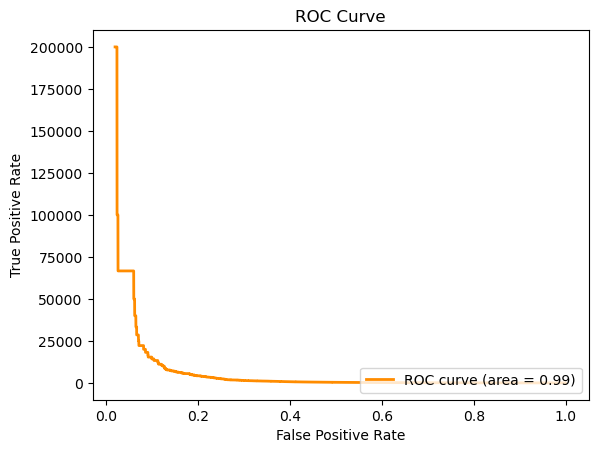

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def get_test_data(bg_file, sig_file, num_events, num_const):
    bg = load_data(bg_file, num_events, num_const)
    sig = load_data(sig_file, num_events, num_const)

    print(f"Using bg {bg.shape} from {bg_file} and sig {sig.shape} from {sig_file}")

    dat = np.concatenate((bg, sig), 0)
    lab = np.append(np.zeros(len(bg)), np.ones(len(sig)))
    padding_mask = dat[:, :, 0] != 0

    idx = np.random.permutation(len(dat))
    dat = torch.tensor(dat[idx])
    lab = torch.tensor(lab[idx])
    padding_mask = torch.tensor(padding_mask[idx])

    test_data = TensorDataset(dat, padding_mask, lab)
    return test_data

def plot_roc_curve(y_true, y_score, model_dir):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(tpr, 1/fpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.5f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(model_dir + '/dsa_roc_test.png')
    return fpr, tpr, roc_auc

def save_roc_data(fpr, tpr, roc_auc, model_dir):
    np.savez(os.path.join(model_dir, 'dsa_roc_data_test.npz'),
             fpr=fpr, tpr=tpr, roc_auc=roc_auc)

def save_auc_score(model_dir, auc_score):
    with open(model_dir + '/dsa_auc.txt', 'w') as file:
        file.write(f'pfn_auc_score\n{auc_score}\n')


model_dir = 'roc_info'
data_path_1 = '/pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/top/discrete/samples_samples_nsamples200000_trunc_5000.h5'
data_path_2 = '/pscratch/sd/n/nishank/humberto/FirstTime_topvsqcd_100const/qcd/discrete/samples__nsamples200000_trunc_5000.h5'
num_const = 100

num_features = 3

print(f"Loading test set")
test_data = get_test_data(data_path_2, data_path_1, 200000, num_const)
test_data_np, test_mask_np, test_labels_np = tensor_to_numpy(test_data)

print("Test data shape:", test_data_np.shape)
print("Test mask shape:", test_mask_np.shape)
print("Test labels shape:", test_labels_np.shape)

# Load PFN model
# model = PFN(
#     input_dim=num_features,
#     Phi_sizes=(100, 100, 256),
#     F_sizes=(100, 100, 100),
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy'],
#     output_dim=1,
#     output_act='sigmoid',
#     filepath='pfn_checkpoints/model_pfn_training_ckpt_epoch_{epoch:02d}.weights.h5',
#     modelcheck_opts={'save_best_only': True, 'verbose': 1, 'save_weights_only': True},
#     earlystop_opts={'restore_best_weights': True, 'verbose': 1, 'patience': 10},
#     save_while_training=True,
#     compile=True,
#     summary=True
# )

# Load best weights
# model.load_weights(os.path.join(model_dir, 'model_pfn_best_ckpt.h5'))

# Evaluate model
predictions = model.predict(test_data_np)
auc_score = roc_auc_score(test_labels_np, predictions)

# Plot and save ROC curve
fpr, tpr, roc_auc = plot_roc_curve(test_labels_np, predictions, model_dir)
save_roc_data(fpr, tpr, roc_auc, model_dir)
save_auc_score(model_dir, auc_score)

print(f"AUC Score: {auc_score:.5f}")